In [1]:
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd
import math
import numpy as np
import pickle
import seaborn as sns

In [2]:
model = xgb.XGBClassifier()
model.load_model('xgboost_abgabe.json')


In [3]:
model.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='dart', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=20,
              missing=-999, monotone_constraints='()', n_estimators=13,
              n_jobs=0, nthread=4, num_parallel_tree=1,
              objective='binary:hinge', predictor='auto', random_state=0, ...)>

**Feature Importances**

Weight: Occurance of feature over all trees

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

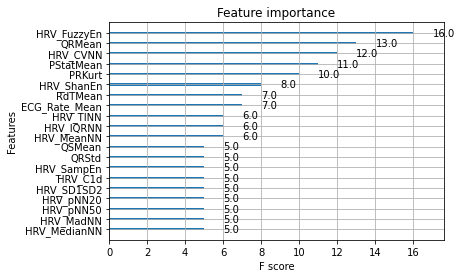

In [4]:
xgb.plot_importance(model, max_num_features=20, importance_type='weight')

Gain: Average gain of splits which use the feature

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

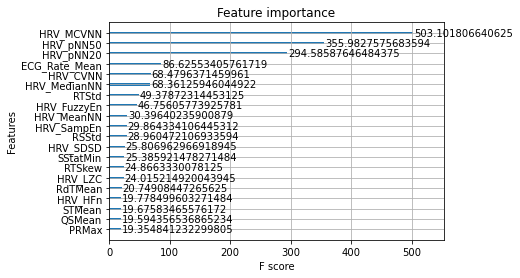

In [5]:
xgb.plot_importance(model, max_num_features=20, importance_type='gain')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

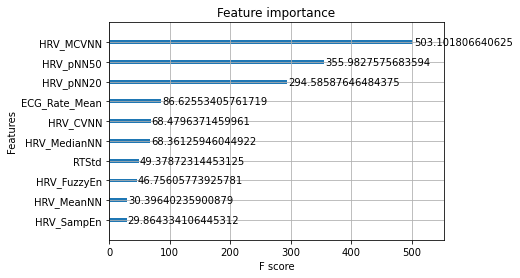

In [6]:
xgb.plot_importance(model, max_num_features=10, importance_type='gain')

Total gain: accumulated gain of feature

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

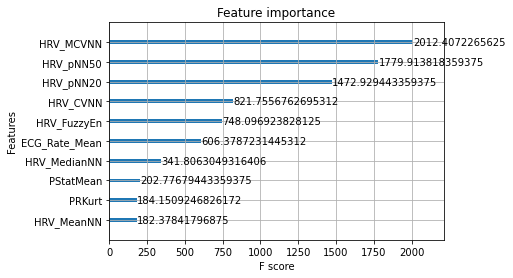

In [7]:
xgb.plot_importance(model, max_num_features=10, importance_type='total_gain')

Cover: average coverage of splits which use the feature where coverage is defined as the number of samples affected by the split

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

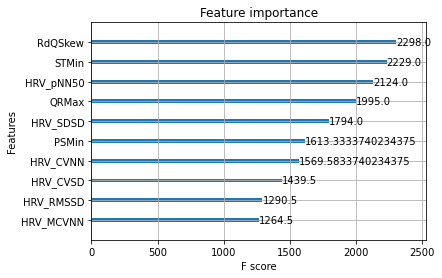

In [8]:
xgb.plot_importance(model, max_num_features=10, importance_type='cover')

Top 50 Features sorted by gain

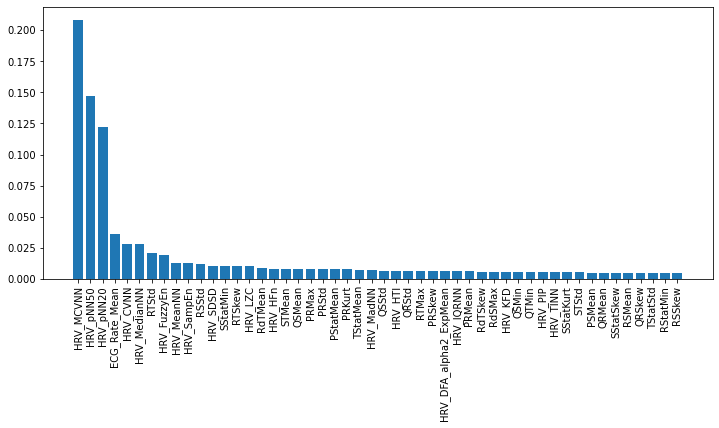

In [9]:
features = model.feature_importances_
featnames = model.feature_names_in_
sortednames = [x for _, x in sorted(zip(features, featnames))]
sortedfeat = sorted(features)
sortedfeat.reverse()
sortednames.reverse()

plt.figure(figsize=(12,5))
plt.bar(sortednames[0:50], sortedfeat[0:50])
plt.xticks(rotation='vertical')
plt.show()

**Combined Feature Ranking of weight and gain**

Top 20 Features sorted by gain with weight and gain

96


<AxesSubplot:>

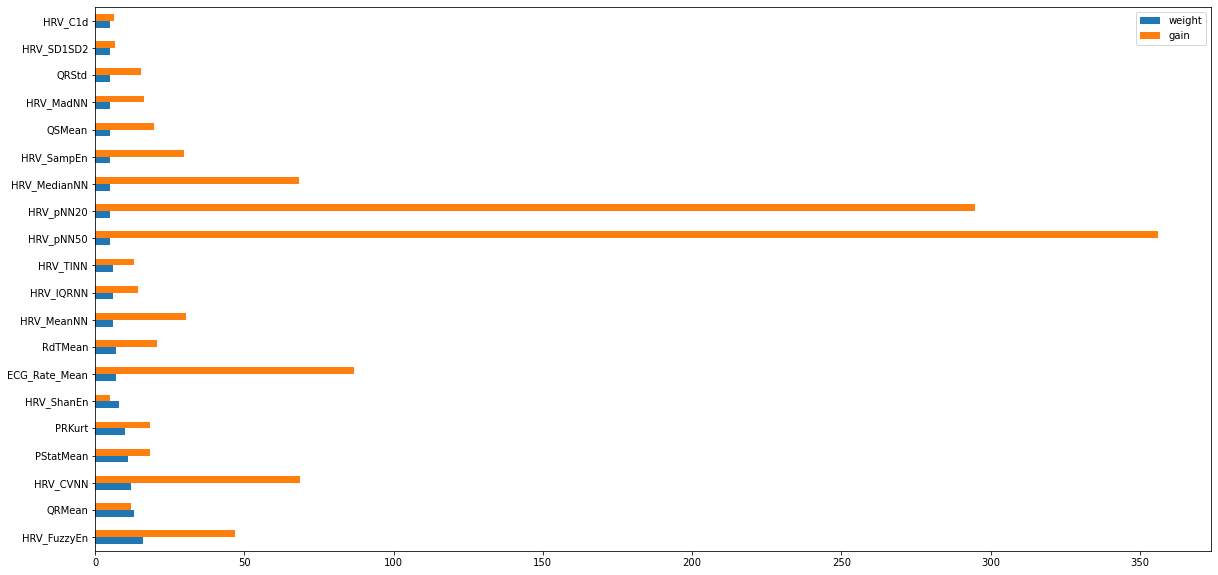

In [10]:
feature_important_w = model.get_booster().get_score(importance_type='weight')
feature_important_g = model.get_booster().get_score(importance_type='gain')

keys_W = list(feature_important_w.keys())
values_W = list(feature_important_w.values())
print(len(keys_W))

keys_G = list(feature_important_g.keys())
values_G = list(feature_important_g.values())

data = pd.DataFrame(data={'weight':values_W, 'gain':values_G}, index=keys_W).sort_values(by = "gain", ascending=False)
data.nlargest(20, columns=["weight","gain"]).plot(kind='barh', figsize = (20,10)) ## plot top 40 features

Custom ranking: features sorted by combining their rank in gain an weight metric

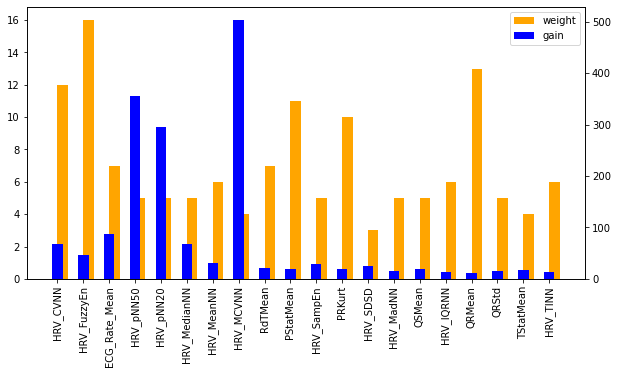

In [11]:
sorted_dict_w = dict(sorted(feature_important_w.items(), key=lambda item: item[1], reverse=True))
sorted_dict_g = dict(sorted(feature_important_g.items(), key=lambda item: item[1], reverse=True))
sorted_dict_w_rank = {}
sorted_dict_w_rank = {}
i  = len(sorted_dict_w)
for key in sorted_dict_w:
    sorted_dict_w[key] = i
    i = i -1
i  = len(sorted_dict_w)
for key in sorted_dict_g:
    sorted_dict_g[key] = i
    i = i -1   

combined_rank = {}
for key in sorted_dict_g:
    combined_rank[key] = (sorted_dict_g[key]+sorted_dict_w[key])/2
combined_rank = dict(sorted(combined_rank.items(), key=lambda item: item[1], reverse=True))

gain = []
weight = []
names = []
for key in combined_rank:
    gain.append(feature_important_g[key])
    weight.append(feature_important_w[key])
    names.append(key)

lim=20
fig, ax = plt.subplots(figsize=(10,5))
plt.xticks(rotation='vertical')
ax2=ax.twinx()
p1 = ax.bar(names[0:lim], weight[0:lim], label='weight',color='orange',align='edge', width=0.4)
p2 = ax2.bar(names[0:lim], gain[0:lim], label='gain', color='blue', width=0.4)
plt.legend(handles=[p1,p2])
plt.show()

Custom ranking: features sorted by multipling gain and weight

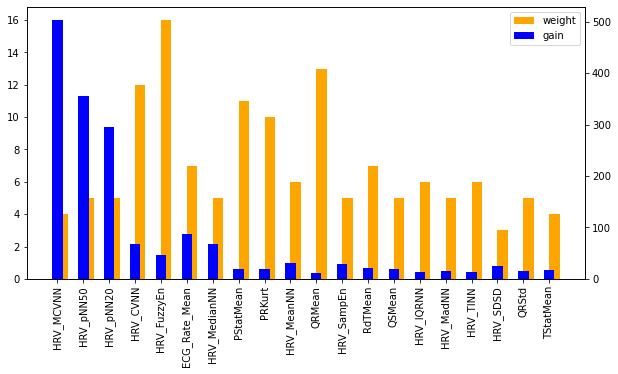

In [12]:
commbinded_feature_importance = {}
for key in feature_important_g:
    commbinded_feature_importance[key]=feature_important_g[key]*feature_important_w[key]

sorted_dict = dict(sorted(commbinded_feature_importance.items(), key=lambda item: item[1], reverse=True))

gain = []
weight = []
combined = []
names = []
for key in sorted_dict:
    gain.append(feature_important_g[key])
    weight.append(feature_important_w[key])
    combined.append(sorted_dict)
    names.append(key)

lim=20
fig, ax = plt.subplots(figsize=(10,5))
plt.xticks(rotation='vertical')
ax2=ax.twinx()
p1 = ax.bar(names[0:lim], weight[0:lim], label='weight',color='orange',align='edge', width=0.4)
p2 = ax2.bar(names[0:lim], gain[0:lim], label='gain', color='blue', width=0.4)
plt.legend(handles=[p1,p2])
plt.show()

**Top Feature correlations to Type (Normal or Afib)**

In [13]:
with open('Neurokit_Dataset.pkl', 'rb') as mit:
    dat = pickle.load(mit)

featkeys= list(keys_W)[0:15]
featkeys.append('TYPE')
dat['TYPE'].replace('A', 1, inplace=True)
dat['TYPE'].replace('N', 0, inplace=True)
print
dat2 = dat[featkeys]

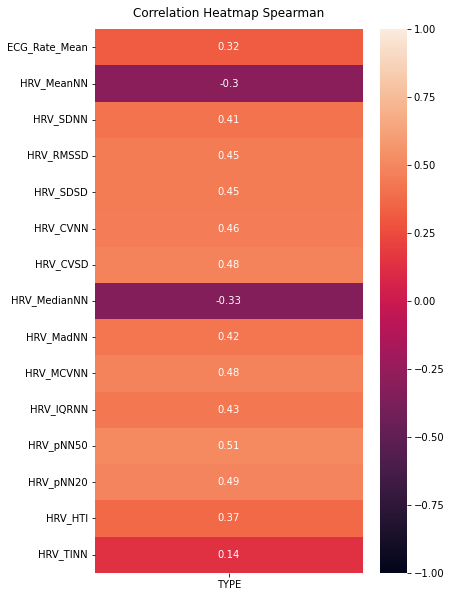

In [14]:
plt.figure(figsize=(6, 10))
heatmap = sns.heatmap(dat2.corr(method='spearman')['TYPE'].to_frame().drop('TYPE'), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap Spearman', fontdict={'fontsize':12}, pad=12);

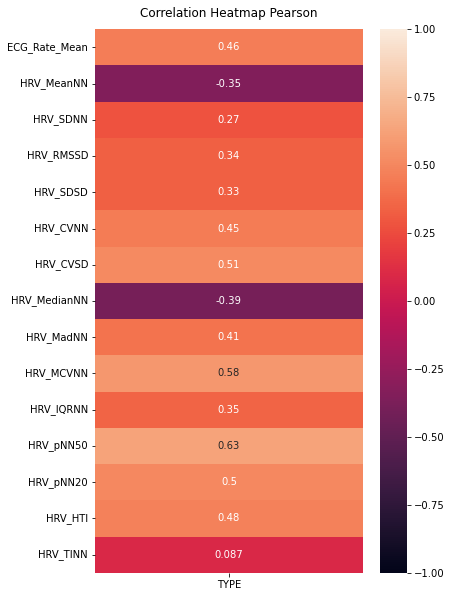

In [15]:
plt.figure(figsize=(6, 10))
heatmap = sns.heatmap(dat2.corr(method='pearson')['TYPE'].to_frame().drop('TYPE'), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap Pearson', fontdict={'fontsize':12}, pad=12);

In [16]:
#sns.pairplot(dat2.sample(500))
#plt.show()

In [17]:
import eli5
eli5.explain_weights_xgboost(model)

Weight,Feature
0.2083,HRV_MCVNN
0.1474,HRV_pNN50
0.1220,HRV_pNN20
0.0359,ECG_Rate_Mean
0.0284,HRV_CVNN
0.0283,HRV_MedianNN
0.0204,RTStd
0.0194,HRV_FuzzyEn
0.0126,HRV_MeanNN
0.0124,HRV_SampEn


In [18]:
df = pd.read_pickle('./Neurokit_Dataset.pkl')
df = df.replace('N', 0)
df = df.replace('A', 1)
# change all infinty values to nan's that can be handled by xgboost
df.replace([np.inf, -np.inf], np.nan, inplace=True)
labels = df['TYPE']
df.drop('TYPE', axis=1, inplace=True)

In [19]:
np.where(labels.values==1)

(array([   8,   25,   30,   34,   59,   60,   67,   74,   78,   81,   82,
          89,   90,  110,  111,  112,  119,  121,  122,  130,  148,  154,
         168,  173,  176,  177,  195,  196,  202,  209,  210,  211,  220,
         222,  224,  239,  242,  248,  271,  302,  308,  312,  324,  332,
         337,  345,  365,  369,  371,  387,  390,  391,  392,  402,  417,
         421,  430,  443,  451,  472,  473,  474,  476,  479,  486,  490,
         491,  494,  495,  497,  511,  513,  514,  520,  526,  540,  541,
         549,  552,  555,  557,  561,  591,  622,  639,  645,  647,  650,
         653,  665,  668,  677,  682,  706,  730,  731,  736,  746,  749,
         764,  766,  767,  780,  786,  787,  789,  790,  793,  806,  813,
         817,  820,  821,  823,  825,  828,  835,  841,  845,  854,  863,
         865,  869,  872,  873,  874,  887,  902,  905,  919,  923,  936,
         939,  940,  945,  947,  952,  957,  979,  987,  990, 1002, 1012,
        1016, 1024, 1026, 1077, 1091, 

In [20]:
print(labels.iloc[0])
eli5.explain_prediction_xgboost(model,df.iloc[0], top=10)


0


Explanation(estimator="XGBClassifier(base_score=0.5, booster='dart', callbacks=None,\n              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,\n              early_stopping_rounds=None, enable_categorical=False,\n              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',\n              importance_type=None, interaction_constraints='',\n              learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,\n              max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=20,\n              missing=-999, monotone_constraints='()', n_estimators=13,\n              n_jobs=0, nthread=4, num_parallel_tree=1,\n              objective='binary:hinge', predictor='auto', random_state=0, ...)", description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=False, targets=[TargetExplanation(target=0, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=1.4555975825458731, std=None, value=1.0), FeatureWeight(feature='HRV_FuzzyEn', weight=0.2100401409069252, std=None, value=0.6078710329681368), FeatureWeight(feature='HRV_pNN50', weight=0.15106889122367356, std=None, value=32.142857142857146), FeatureWeight(feature='HRV_MeanNN', weight=0.12595790217982364, std=None, value=1039.4047619047617), FeatureWeight(feature='HRV_MCVNN', weight=0.1241342712489106, std=None, value=0.0385090909090909), FeatureWeight(feature='QRMean', weight=0.12326343868858347, std=None, value=13.310344827586206), FeatureWeight(feature='HRV_pNN20', weight=0.0756703744130245, std=None, value=39.285714285714285)], neg=[FeatureWeight(feature='HRV_CVNN', weight=-0.32519059826521746, std=None, value=0.22245062563270437), FeatureWeight(feature='TStatKurt', weight=-0.11970549476443235, std=None, value=-0.548307502535557), FeatureWeight(feature='HRV_TINN', weight=-0.09917051016, std=None, value=671.875)], pos_remaining=22, neg_remaining=13), proba=1.0, score=-1.7497259204000002, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

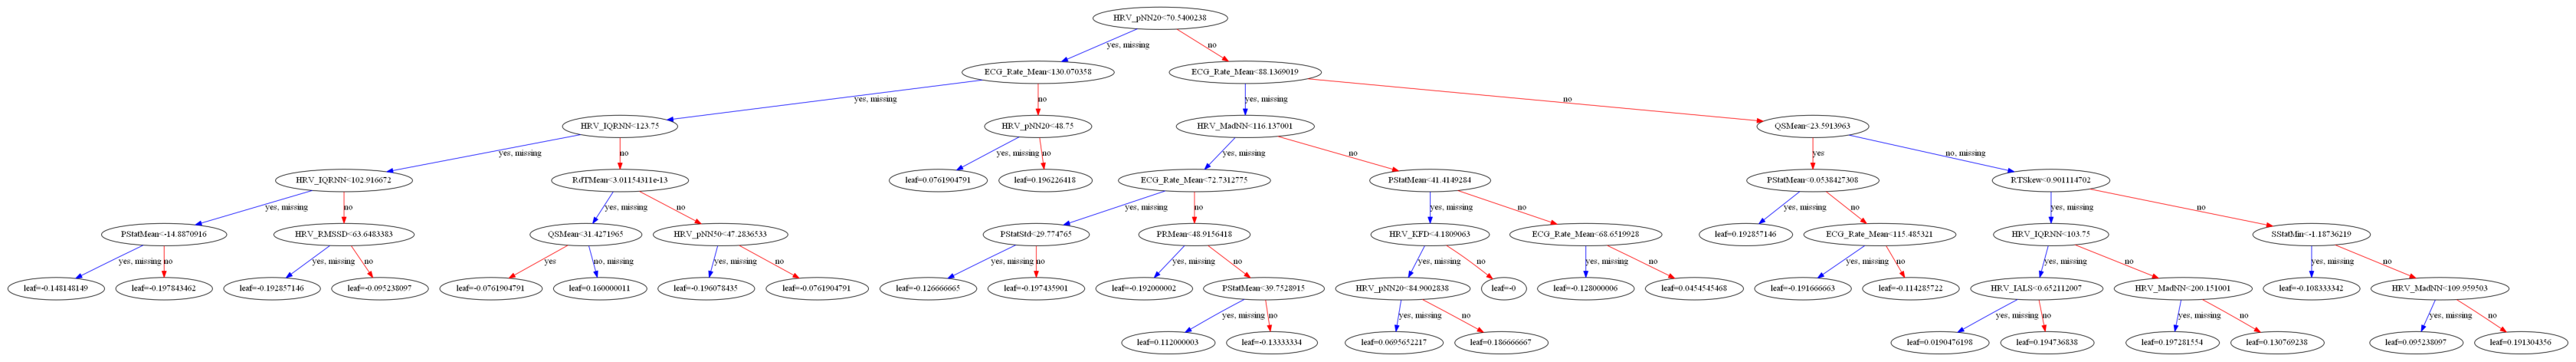

In [28]:
fig, ax = plt.subplots(figsize=(60, 30))
xgb.plot_tree(model,num_trees=0, ax=ax)
plt.show()


In [22]:
import graphviz

In [32]:
mod = xgb.Booster()
mod.load_model('xgboost_abgabe.json')

In [35]:
mod.get_split_value_histogram(feature='HRV_FuzzyEn', fmap='', bins=None, as_pandas=True)

,SplitValue,Count
0,0.516549,1.0
1,0.986936,2.0
2,1.045734,2.0
3,1.163331,1.0
4,1.222129,3.0
5,1.280928,2.0
6,1.339726,1.0
7,1.398524,4.0
